# Estatísticas de contagem

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sys

sys.path.insert(0, "../")

from scipy.optimize import curve_fit
from scipy.signal import gaussian
from scipy.ndimage import filters
from scipy.integrate import simps
from scipy.stats import chisquare

from common import *

%matplotlib inline

Neste experimento, checamos as estatísticas de contagem do detector usado. Para isso utilizamos o programa de aquisição no modo MCS com uma fonte de ${}^{137}$Cs e uma janela de observação na região da linha de 661 keV. Neste modo, o detector conta o número de eventos (cintilações) com energia dentro de uma faixa determinada (no nosso caso, a linha do Césio) ocorridos dentro de um intervalo de tempo chamado _dwell time_. Este processo é repetido 1024 vezes, e com isto conseguimos dados sobre a distribuição do número de contagens obtidas neste tempo. No nosso caso, tomamos as medidas para 3 valores de _dwell time_: 0.4, 4 e 10 s.

Sabe-se (ruby1977) que a distribuição do número de partículas emitidas por amostras radioativas num tempo fixo é um processo binomial, que pode ser aproximado (quando o número de núcleos emitindo é muito grande e a probabilidade de decaimento de um dado núcleo no período de tempo observado é muito pequeno, mas o produto de ambos - o número médio de decaimentos - é finito) por uma distribuição poissoniana.

Outros processos aleatórios contribuem para a variância observada do número de contagens, envolvendo o processo de detecção da radiação no espectrômetro. A soma de todos estes processos é, tipicamente, poissoniana (joyce1969), i.e., a probabilidade de contarmos $k$ partículas num intervalo de tempo fixado $t$ é

$$ P(k) = e^{-\lambda} \frac{\lambda^k}{k!} $$

onde $\lambda$ é o valor esperado do número de contagens, $\lambda = \text{E} \left[ k \right]$. Além disso, a variância do número de contagens é, no caso de uma distribuição de Poisson, dada por $\text{Var}\left[k\right] = \lambda$.

Neste experimento estamos mais interessados nas distribuições das taxas de contagens, isto é, no número de contagens pelo tempo transcorrido. Sendo esta taxa dada por $A = \frac{k}{t}$, onde $t$ é o _dwell time_, temos

$$ \text{E}\left[A \right] = \frac{\lambda}{t} $$
$$ \text{Var}\left[A \right] = \frac{\lambda}{t^2} = \frac{\lambda}{t} $$

Estimando a partir dos dados experimentais a média da distribuição como a média das taxas de contagens observadas $\left\langle A \right\rangle$ podemos também inferir que o desvio padrão distribuição é

$$ \sigma = \sqrt{\frac{\left\langle A \right\rangle}{t}} $$

Com os dados brutos coletados podemos, portanto, observar o histograma das taxas de contagens para os valores de _dwell time_ utilizados. Apenas com a média da taxa de contagens obtida em cada uma das medidas podemos determinar a distribuição de Poisson adequada, já que o desvio padrão é dado pela equação acima. Fizemos então histogramas destes dados, superpostos a gaussianas com média e desvio padrão computados com a hipótese de que os dados são poissonianos (quando o número de contagens é grande tipicamente podemos transitar impunemente entre as distribuições gaussiana e poissoniana [ruby1977, gucker1971]) e observamos, visualmente, um bom acordo entre o modelo e as medições.

In [3]:
data_dir = '../../dados/'

# dados para cada valor de dwell time
arquivos = {
    0.4 : os.path.join(data_dir, 'exp9_cs_400ms22032017_1745.tsv'),
    4 : os.path.join(data_dir, 'exp9_cs_4s29032017_1846.tsv'),
    10 : os.path.join(data_dir, 'cs137_CONTAGEM_dwell10s.tsv'),
}

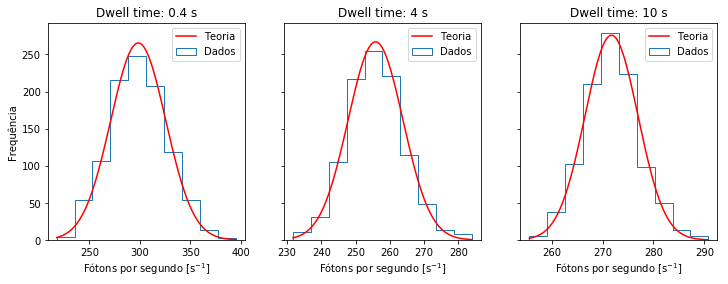

In [4]:
dwells = list(arquivos.keys())
dwells.sort()

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
axs[0].set_ylabel("Frequência")
for i, dwell in enumerate(dwells):
    _, contagens = load_data(arquivos[dwell])
    
    #calcula taxa de contagens
    atividade = contagens / dwell
    
    #infere média e desvio padrão
    media = np.mean(atividade)
    std = np.sqrt(media/dwell)
    
    #plota histograma dos dados medidos
    ax = axs[i]
    ax.set_xlabel("Fótons por segundo [s$^{-1}$]")
    ax.set_title("Dwell time: " + str(dwell) + " s")
    histograma = ax.hist(atividade, histtype='step', label="Dados")
    
    bins = histograma[1]
    counts = histograma[0]    
    
    #é necessário escalar a distribuição gaussiana de forma que as integrais dos dados e da gaussiana coincidam
    scale = sum([(right - left) * count for right, left, count in zip(bins[1:], bins, counts)])

    #calcula gaussiana
    xs = np.linspace(atividade.min(), atividade.max(), 2000)
    ys = scale*mlab.normpdf(xs, media, std)
    
    #plota modelo teórico (gaussiano)
    ax.plot(xs, ys, 'r', label="Teoria")
    ax.legend()

Note que, visualmente, o modelo teórico ajusta muito bem os dados obtidos. Observe ainda que, quanto maior o tempo de aquisição, menor é o desvio padrão das medidas. Isto concorda tanto com o senso comum, de que as médias ficam mais definidas para um maior número de medidas, quanto com a expressão obtida anteriormente para a variância da taxa de contagens.

In [13]:
fig.savefig("estatisticas.pdf")